<a href="https://colab.research.google.com/github/rizalpangestu1/Machine-Learning/blob/main/GymLens_Training_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from ipywidgets import FileUpload
import io

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
# Dataset directory
DATASET_DIR = '/content/drive/MyDrive/C242-PS284/Gym Dataset Cropped'

Mounted at /content/drive


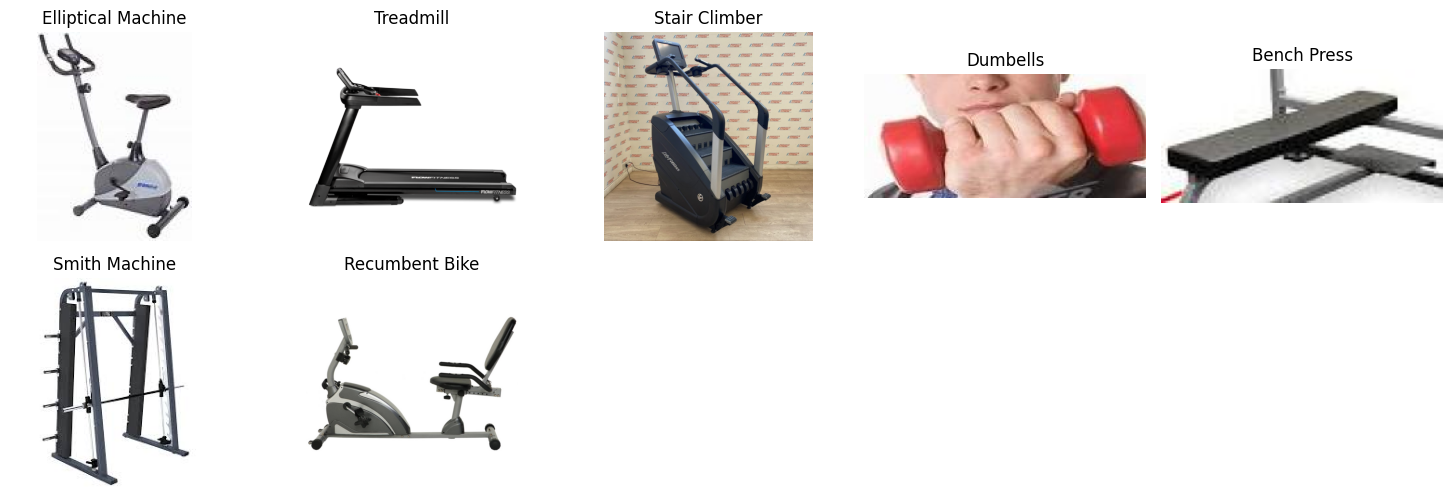

In [3]:
# Function to preprocess and handle images
def preprocess_image(image_path):
    """
    Open an image, convert to RGBA format if necessary, and return the processed image.
    """
    img = Image.open(image_path)
    if img.mode in ('P', 'L') or ('transparency' in img.info):
        img = img.convert('RGBA')
    return img

# Function to display sample images
def display_sample_images(data_dir, max_classes=19):
    """
    Display one sample image from each class in the dataset.
    """
    try:
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        plt.figure(figsize=(15, 10))

        for i, cls in enumerate(classes[:max_classes]):
            cls_path = os.path.join(data_dir, cls)
            if os.path.isdir(cls_path):
                image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
                if image_files:
                    image_path = os.path.join(cls_path, image_files[0])
                    img = preprocess_image(image_path)

                    plt.subplot(4, 5, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Display sample images
display_sample_images(DATASET_DIR)


In [4]:
# Data Generators
batch_size = 128
train_datagen = ImageDataGenerator(
    validation_split=0.2,  # Split 20% for validation
    rescale=1.0 / 255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),  # Smaller input size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print("Number of classes:", len(train_generator.class_indices))
print("Number of training images:", train_generator.n)
print("Number of validation images:", validation_generator.n)


Found 876 images belonging to 7 classes.
Found 216 images belonging to 7 classes.
Number of classes: 7
Number of training images: 876
Number of validation images: 216


In [5]:
# Define the model using MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model to speed up training

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# EarlyStoppingCallback for accuracy >= 98%
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.999)

In [18]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 912ms/step - accuracy: 0.9860 - loss: 0.0421 - val_accuracy: 0.9815 - val_loss: 0.0532
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.9862 - loss: 0.0379 - val_accuracy: 0.9907 - val_loss: 0.0595
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 901ms/step - accuracy: 0.9912 - loss: 0.0210 - val_accuracy: 0.9815 - val_loss: 0.0541
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 603ms/step - accuracy: 0.9983 - loss: 0.0119 - val_accuracy: 0.9861 - val_loss: 0.0798
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9971 - loss: 0.0122 - val_accuracy: 0.9907 - val_loss: 0.0527
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - accuracy: 0.9993 - loss: 0.0091 - val_accuracy: 0.9861 - val_loss: 0.0506
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - accuracy: 0.9997 - loss: 0.0061 - val_accuracy: 0.9861 - val_loss: 0.0378
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 900ms/step - accuracy: 0.9982 - loss: 0.0053 - val_accuracy: 0.9907 - v

In [16]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9798 - loss: 0.1184
Validation Loss: 0.11453726887702942
Validation Accuracy: 0.9814814925193787


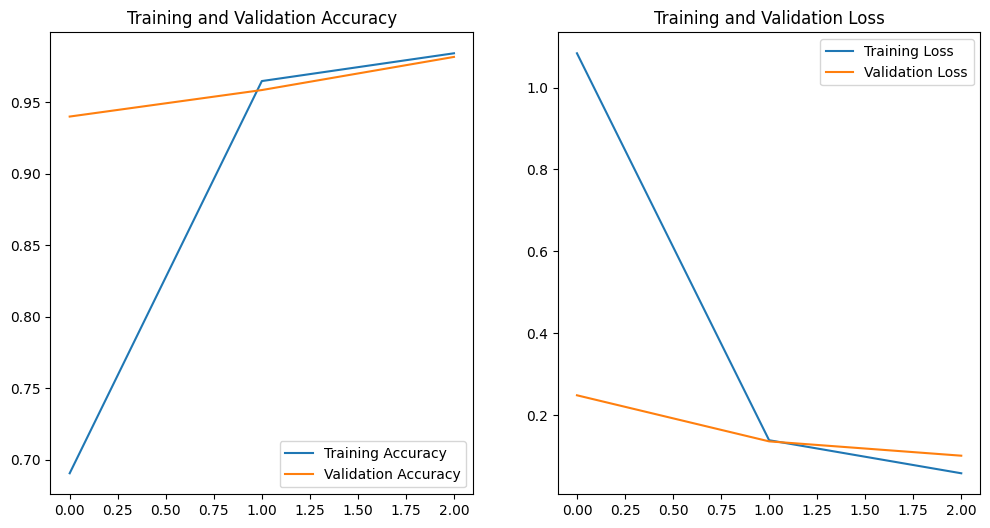

In [9]:
# Plot training history
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


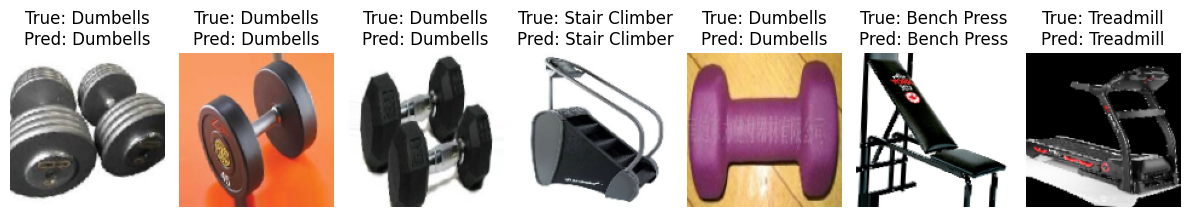

In [10]:
# Test with some validation images
def test_model_with_sample_images(validation_generator, model, num_samples=7):
    """
    Display predictions on sample validation images along with true labels.
    """
    # Get a batch of images and labels from the validation set
    images, labels = next(validation_generator)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i]
        label = labels[i]

        # Predict the class of the image
        prediction = model.predict(img.reshape(1, *img.shape))
        predicted_label = list(validation_generator.class_indices.keys())[prediction.argmax()]
        true_label = list(validation_generator.class_indices.keys())[label.argmax()]

        # Display the image with the predicted and true labels
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on sample images
test_model_with_sample_images(validation_generator, model)

In [11]:
# Generate predictions and true labels from the test set
def evaluate_on_test_set(model, test_generator):
    """
    Generate predictions on the test set and display a confusion matrix.

    Parameters:
    - model: Trained Keras model.
    - test_generator: Data generator for the test set.

    Returns:
    - y_true: True labels.
    - y_pred: Predicted labels.
    """
    # Get predictions and true labels
    y_pred = []
    y_true = []

    for images, labels in test_generator:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels, axis=1))

        # Break when we've iterated over all samples
        if len(y_true) >= test_generator.n:
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
    disp.plot(xticks_rotation='vertical', cmap='viridis')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    return y_true, y_pred


Found 1092 images belonging to 7 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

Classification Report:
                    precision    recall  f1-score   support

       Bench Press       1.00      0.99      0.99       136
          Dumbells       1.00      1.00      1.00       667
Elliptical Machine       1.00      0.81      0.89        77
    Recumbent Bike       0.84      1.00      0.91        83
     Smith Machine       1.00      1.00      1.00        30
     Stair Climber       0.94      0.94      0.94        36
         Treadmill       0.98      0.95      0.97        63

          accuracy                           0.98      1092
         macro avg       0.97      0.96      0.96   

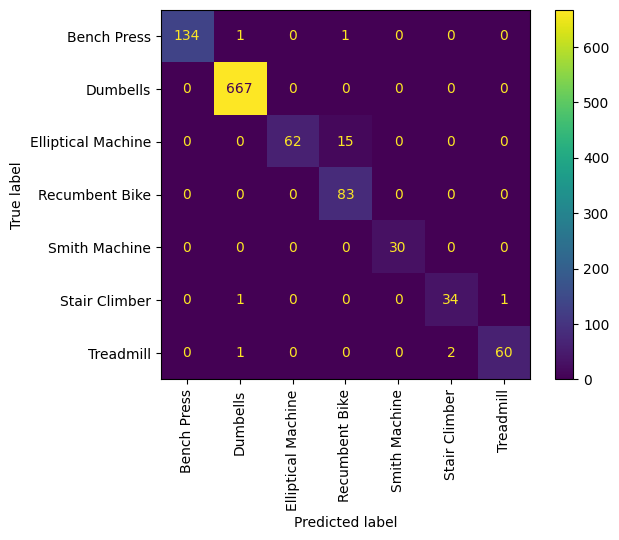

In [12]:
# Test Generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescaling
test_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Maintain order for accurate results
)

# Evaluate the model on the test set
y_true, y_pred = evaluate_on_test_set(model, test_generator)

In [13]:
def upload_and_test(model, target_size, class_indices):
    """
    Upload file, preprocess, and predict using the trained model.

    Parameters:
    - model: Trained Keras model.
    - target_size: Tuple (width, height) for resizing the input image.
    - class_indices: Dictionary of class labels and indices.

    Returns:
    None
    """
    # Upload file widget
    uploader = FileUpload(accept='image/*', multiple=False)
    display(uploader)

    def on_upload(change):
        # Load and preprocess the uploaded image
        for name, file_info in uploader.value.items():
            img = Image.open(io.BytesIO(file_info['content'])) # 'io' is now defined
            img = img.resize(target_size)  # Resize image to match model input size
            img_array = img_to_array(img) / 255.0  # Normalize image data
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input

            # Predict
            prediction = model.predict(img_array)
            predicted_label = list(class_indices.keys())[np.argmax(prediction)]
            confidence = np.max(prediction)

            # Show the uploaded image and prediction
            plt.imshow(img)
            plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}%)")
            plt.axis('off')
            plt.show()

    uploader.observe(on_upload, names='value')

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


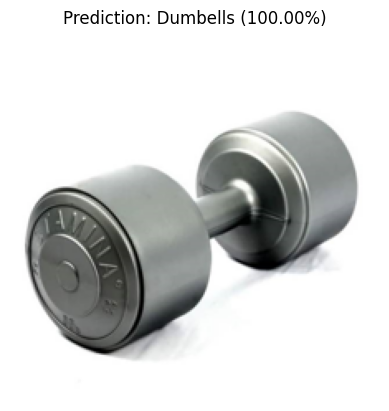

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


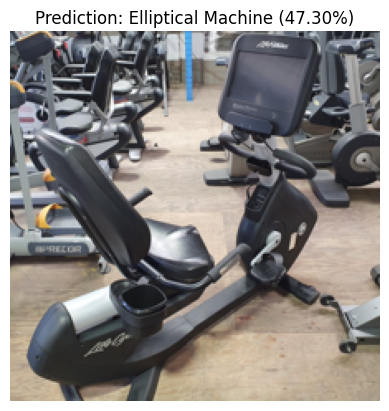

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


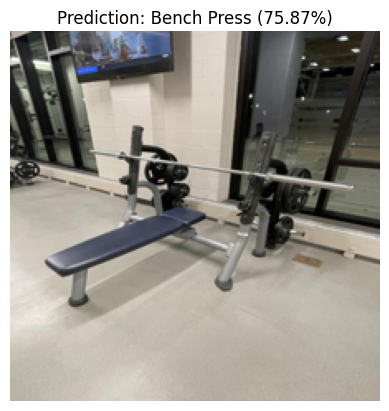

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


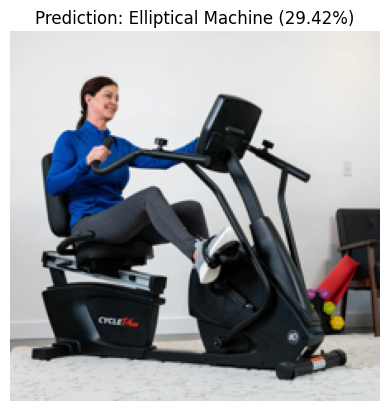

In [14]:
upload_and_test(model, target_size=(224, 224), class_indices=validation_generator.class_indices)


In [15]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/C242-PS284/saved_model/gym_model_MobileNetV2.h5
